In [1]:
import torch, torchvision
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat

import numpy as np

from PIL import Image

import kornia

from apply_flow import apply_flow

device='cuda'

H, W = 224, 224
BATCH_SIZE = 1


to_tensor = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize([224, 224])
    ]
)

normalize = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  

img = Image.open("./bulbul.jpeg") 
# img = Image.open("./img.png")

img_batch = repeat(to_tensor(img), 'h w c -> b h w c', b=BATCH_SIZE).to(device)
# img_batch = torch.rand(1, 3, 224, 224) * 0.1 + 0.5


flow_batch = torch.randn((BATCH_SIZE, H, W, 2), device=device)
flow_batch.requires_grad = True


optimizer = torch.optim.Adam([flow_batch], lr=0.1)


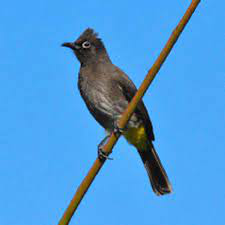

In [2]:
img

In [3]:
net = torchvision.models.resnet50(pretrained=True).cuda().eval()

with torch.no_grad():
    
    scores = net(normalize(img_batch))
    probs  = torch.softmax(scores, dim=-1)
    img_class = scores.argmax(dim=-1)
    class_prob = probs[:, img_class]

In [4]:
scores.shape

torch.Size([1, 1000])

In [5]:
print(f'Network sees {img_class.item()} with probability {class_prob.item()}')

Network sees 16 with probability 0.9995119571685791


In [6]:
import tqdm



for n in tqdm.tqdm(range(1000)): 
    applied_flow_batch = flow_batch
    
    applied_flow_batch = torch.tanh(flow_batch) * 0.1
    normalized_img_batch = normalize(img_batch)
    
    flowed_img_batch = apply_flow(normalized_img_batch, applied_flow_batch)
    out = net(flowed_img_batch)
    
    target = torch.ones(out.shape[0], dtype=torch.long, device=out.device) * 309 #img_class.item()
    loss   = torch.nn.functional.cross_entropy(out, target)
    
    #     target = out[:, 668].mean()
#     loss = -target
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


100%|██████████| 1000/1000 [00:17<00:00, 55.88it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


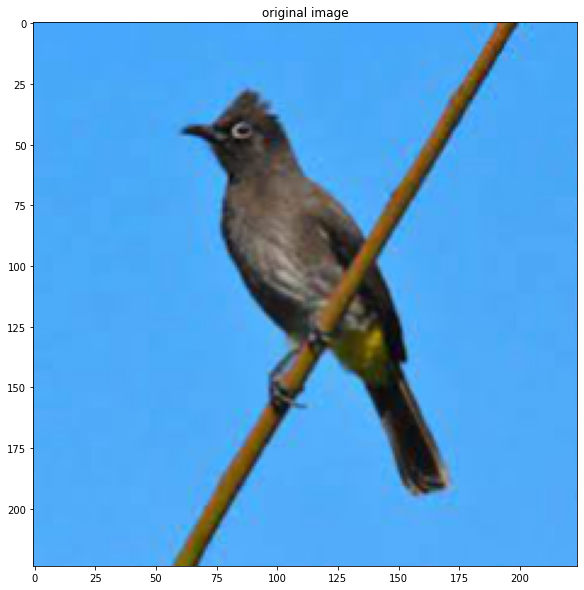

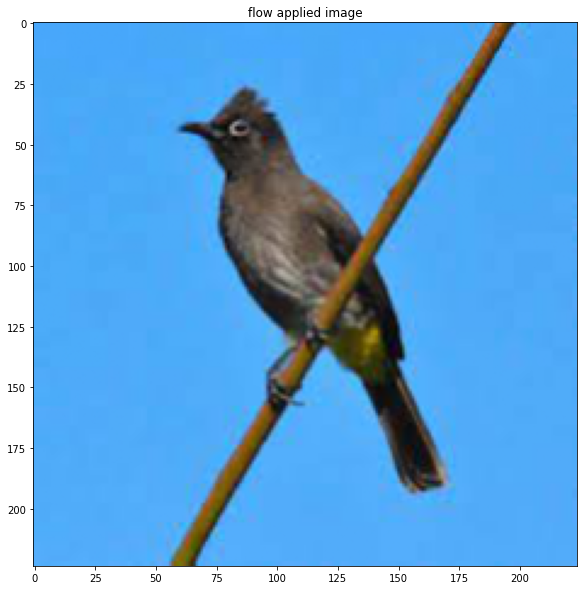

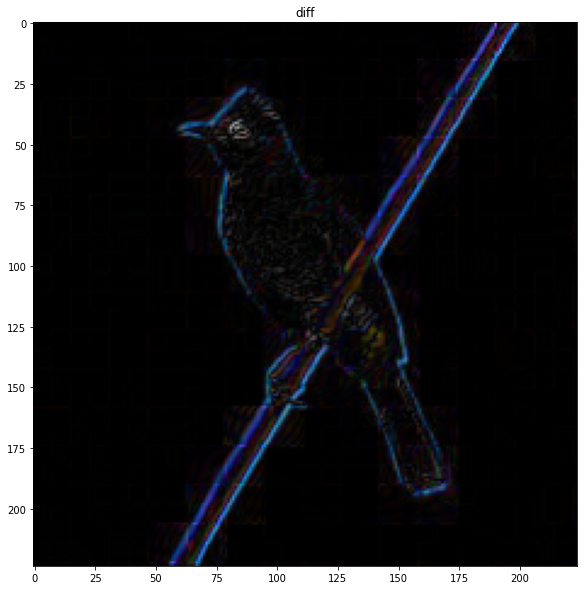

Network sees 16 with probability 0.9996753931045532


In [11]:

applied_flow_batch = torch.ones((BATCH_SIZE, H, W, 2), device=device) * 1
flowed_img = apply_flow(img_batch, applied_flow_batch)
abs_diff = abs(img_batch - flowed_img)
normalized_abs_diff = (abs_diff - abs_diff.min()) / (abs_diff.max() - abs_diff.min())



plt.figure(figsize=[10,10])
plt.imshow(kornia.tensor_to_image(img_batch)); plt.title('original image'); plt.show()

plt.figure(figsize=[10,10])
plt.imshow(kornia.tensor_to_image(flowed_img)); plt.title('flow applied image'); plt.show()

plt.figure(figsize=[10,10])
plt.imshow(kornia.tensor_to_image(normalized_abs_diff)); plt.title('diff'); plt.show()


with torch.no_grad():
    # applied_flow_batch = torch.randn((BATCH_SIZE, H, W, 2), device=device)
    scores = net(apply_flow(normalize(img_batch), applied_flow_batch))
    probs  = torch.softmax(scores, dim=-1)
    img_class = scores.argmax(dim=-1)
    class_prob = probs[:, img_class]
    
    
print(f'Network sees {img_class.item()} with probability {class_prob.item()}')